In [2]:
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import matplotlib.pyplot as plt
from lataq.models import EMBEDCVAE
from lataq_reproduce.exp_dict import EXPERIMENT_INFO
from sklearn.metrics import classification_report

%load_ext autoreload
%autoreload 2

Global seed set to 0


In [14]:
plt.rcParams['figure.dpi'] = 600

In [33]:
results_df = pd.read_pickle('./../benchmarks/benchmarks_new_fixed.pkl')

In [34]:
results_df['method'] = results_df['method'].astype('category')
results_df['method'] = results_df['method'].cat.rename_categories(
    {
        'embedcvae': 'PoLIE',
        'lataq_noland': 'PoLIE - land',
        'tranvae': 'trVAE + land',
        'scanvi': 'scANVI',
        'scvi': 'scVI',
        'mars': 'MARS',
        'svm': 'SVM',
        'seurat': 'Seurat v3',
        'symphony': 'Symphony'
    }
)

In [ ]:
results_df['config.data'] = results_df['config.data'].astype('category')
results_df['config.data'] = results_df['config.data'].cat.rename_categories(
    {
        'pancreas': 'Pancreas',
        'pbmc': 'Immune',
        'tranvae': 'trVAE + land',
        'scanvi': 'scANVI',
        'scvi': 'scVI',
        'mars': 'MARS',
        'svm': 'SVM',
        'seurat': 'Seurat v3',
        'symphony': 'Symphony'
    }
)

In [35]:
integration_methods = ['scANVI', 'scVI', 'Seurat v3', 'Symphony', 'CVAE + land', 'PoLIE', 'PoLIE - land']
classification_methods = ['scANVI', 'Seurat v3', 'SVM', 'MARS', 'CVAE + land', 'PoLIE']

In [36]:
map_metrics = {
    'result.NMI_cluster/label': 'bio conservation', 
    'result.ARI_cluster/label': 'bio conservation',
    'result.ASW_label': 'bio conservation', 
    'result.ASW_label/batch': 'batch correction', 
    'result.PCR_batch': 'batch correction',
    'result.isolated_label_F1': 'bio conservation', 
    'result.isolated_label_silhouette': 'bio conservation',
    'result.graph_conn': 'batch correction',
}


In [37]:
results_df['integration_scores_mean'] = results_df[[
    'result.NMI_cluster/label',
    'result.ARI_cluster/label',
    'result.ASW_label',
    'result.ASW_label/batch',
    'result.PCR_batch',
    'result.isolated_label_F1',
    'result.isolated_label_silhouette',
    'result.graph_conn',
]].mean(axis=1)

In [38]:
results_df['bio_conservation_mean'] = results_df[[
    'result.NMI_cluster/label',
    'result.ARI_cluster/label',
    'result.ASW_label',
    'result.isolated_label_F1',
    'result.isolated_label_silhouette',
]].mean(axis=1)
results_df['batch_correction_mean'] = results_df[[
    'result.ASW_label/batch',
    'result.PCR_batch',
    'result.graph_conn',
]].mean(axis=1)
results_df['integration_scores_weighted_mean'] = 0.4*results_df['batch_correction_mean'] + 0.6*results_df['bio_conservation_mean']

In [39]:
results_melt = pd.melt(results_df, id_vars = ['config.data', 'method'])
results_melt = results_melt[~results_melt['variable'].str.contains('time')]
results_melt['method'] = results_melt['method'].astype('category')
results_melt['method'] = results_melt['method'].cat.reorder_categories(
    [
        'PoLIE',
        'PoLIE - land',
        'trVAE + land',
        'scVI',
        'scANVI',
        'MARS',
        'Seurat v3',
        'Symphony',
        'SVM'
    ]
)

In [40]:
results_melt['metric_type'] = results_melt['variable'].map(map_metrics)

In [41]:
results_melt

,config.data,method,variable,value,metric_type
108,pancreas,scANVI,result.NMI_cluster/label,0.925007,bio conservation
109,pbmc,scANVI,result.NMI_cluster/label,0.886107,bio conservation
110,brain,scANVI,result.NMI_cluster/label,0.711047,bio conservation
111,scvelo,scANVI,result.NMI_cluster/label,0.612339,bio conservation
112,tumor,scANVI,result.NMI_cluster/label,0.474573,bio conservation
...,...,...,...,...,...
859,pbmc,Symphony,integration_scores_weighted_mean,0.757735,NaN
860,scvelo,Symphony,integration_scores_weighted_mean,0.545792,NaN
861,lung,Symphony,integration_scores_weighted_mean,0.612712,NaN
862,tumor,Symphony,integration_scores_weighted_mean,0.548210,NaN


In [42]:
results_melt.groupby(['method', 'variable']).mean()

value
method variable                                  
PoLIE  batch_correction_mean             0.689169
       bio_conservation_mean             0.714558
       integration_scores_mean           0.705037
       integration_scores_weighted_mean  0.704403
       result.ARI_cluster/label          0.651794
...                                           ...
SVM    result.f1-score-macro             0.732632
       result.f1-score-weighted          0.795340
       result.graph_conn                      NaN
       result.isolated_label_F1               NaN
       result.isolated_label_silhouette       NaN

[126 rows x 1 columns]

In [43]:
palette_dict = {
    'PoLIE': '#6b00b3',
    'PoLIE - land': '#ad33ff',
    'trVAE + land': '#e0b3ff',
    'scVI': '#3498DB',
    'scANVI': '#85C1E9',
    'MARS': '#616A6B',
    'Seurat v3': '#CB4335',
    'Symphony': '#F1948A',
    'SVM': '#F7DC6F'
}

In [44]:
results_melt[results_melt['variable'] == 'integration_scores_mean']

,config.data,method,variable,value,metric_type
648,pancreas,scANVI,integration_scores_mean,0.733344,NaN
649,pbmc,scANVI,integration_scores_mean,0.820540,NaN
650,brain,scANVI,integration_scores_mean,0.639530,NaN
651,scvelo,scANVI,integration_scores_mean,0.606063,NaN
652,tumor,scANVI,integration_scores_mean,0.558503,NaN
653,lung,scANVI,integration_scores_mean,0.650825,NaN
654,pancreas,scVI,integration_scores_mean,0.732511,NaN
655,pbmc,scVI,integration_scores_mean,0.775826,NaN
656,brain,scVI,integration_scores_mean,0.613147,NaN
657,scvelo,scVI,integration_scores_mean,0.493400,NaN


In [45]:
df_plot = results_melt[
    (results_melt['method'].isin(integration_methods))
    & (results_melt['variable'] == 'integration_scores_weighted_mean')
]
df_plot['method'] = df_plot['method'].cat.remove_unused_categories()

mean_df = df_plot.groupby('method').mean()
mean_df = mean_df.reset_index()
mean_df['index'] = 'avg'
mean_df.columns = ['method', 'value', 'config.data']
df_plot = df_plot.append(mean_df)

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.barplot(
    x='config.data',
    y='value',
    hue='method',
    data=df_plot,
    palette=palette_dict,
    ax=ax
)
ax.set_title('Integration scores mean')
ax.set_ylabel('Score')
ax.set_xlabel('Dataset')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., frameon=False)
ax.set_ylim([0, 0.85])
ax.grid('off')
ax.grid(b=None)
sns.despine(offset=5)
fig.savefig('figure2/benchmark_integration.png', dpi=600, bbox_inches='tight')

<ipython-input-45-98abc756608d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['method'] = df_plot['method'].cat.remove_unused_categories()


In [46]:
df_plot = results_melt[
    (results_melt['method'].isin(integration_methods))
    & (results_melt['config.data'] == 'tumor')
]
df_plot['method'] = df_plot['method'].cat.remove_unused_categories()

<ipython-input-46-c688da52545a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['method'] = df_plot['method'].cat.remove_unused_categories()


In [47]:
df_plot = results_melt[
    (results_melt['method'].isin(integration_methods))
]
df_plot['method'] = df_plot['method'].cat.remove_unused_categories()

mean_df = df_plot.groupby(['method', 'metric_type']).mean()
mean_df = mean_df.reset_index()
mean_df['index'] = 'avg'
mean_df.columns = ['method', 'metric_type', 'value', 'config.data']
df_plot = df_plot.append(mean_df)

df_plot

<ipython-input-47-773848356aa8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['method'] = df_plot['method'].cat.remove_unused_categories()


,config.data,method,variable,value,metric_type
108,pancreas,scANVI,result.NMI_cluster/label,0.925007,bio conservation
109,pbmc,scANVI,result.NMI_cluster/label,0.886107,bio conservation
110,brain,scANVI,result.NMI_cluster/label,0.711047,bio conservation
111,scvelo,scANVI,result.NMI_cluster/label,0.612339,bio conservation
112,tumor,scANVI,result.NMI_cluster/label,0.474573,bio conservation
...,...,...,...,...,...
7,avg,scANVI,NaN,0.656341,bio conservation
8,avg,Seurat v3,NaN,0.708210,batch correction
9,avg,Seurat v3,NaN,0.609780,bio conservation
10,avg,Symphony,NaN,0.728629,batch correction


<ipython-input-48-874adbe675d5>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['method'] = df_plot['method'].cat.remove_unused_categories()
/home/icb/carlo.dedonno/anaconda3/envs/lataq_cuda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


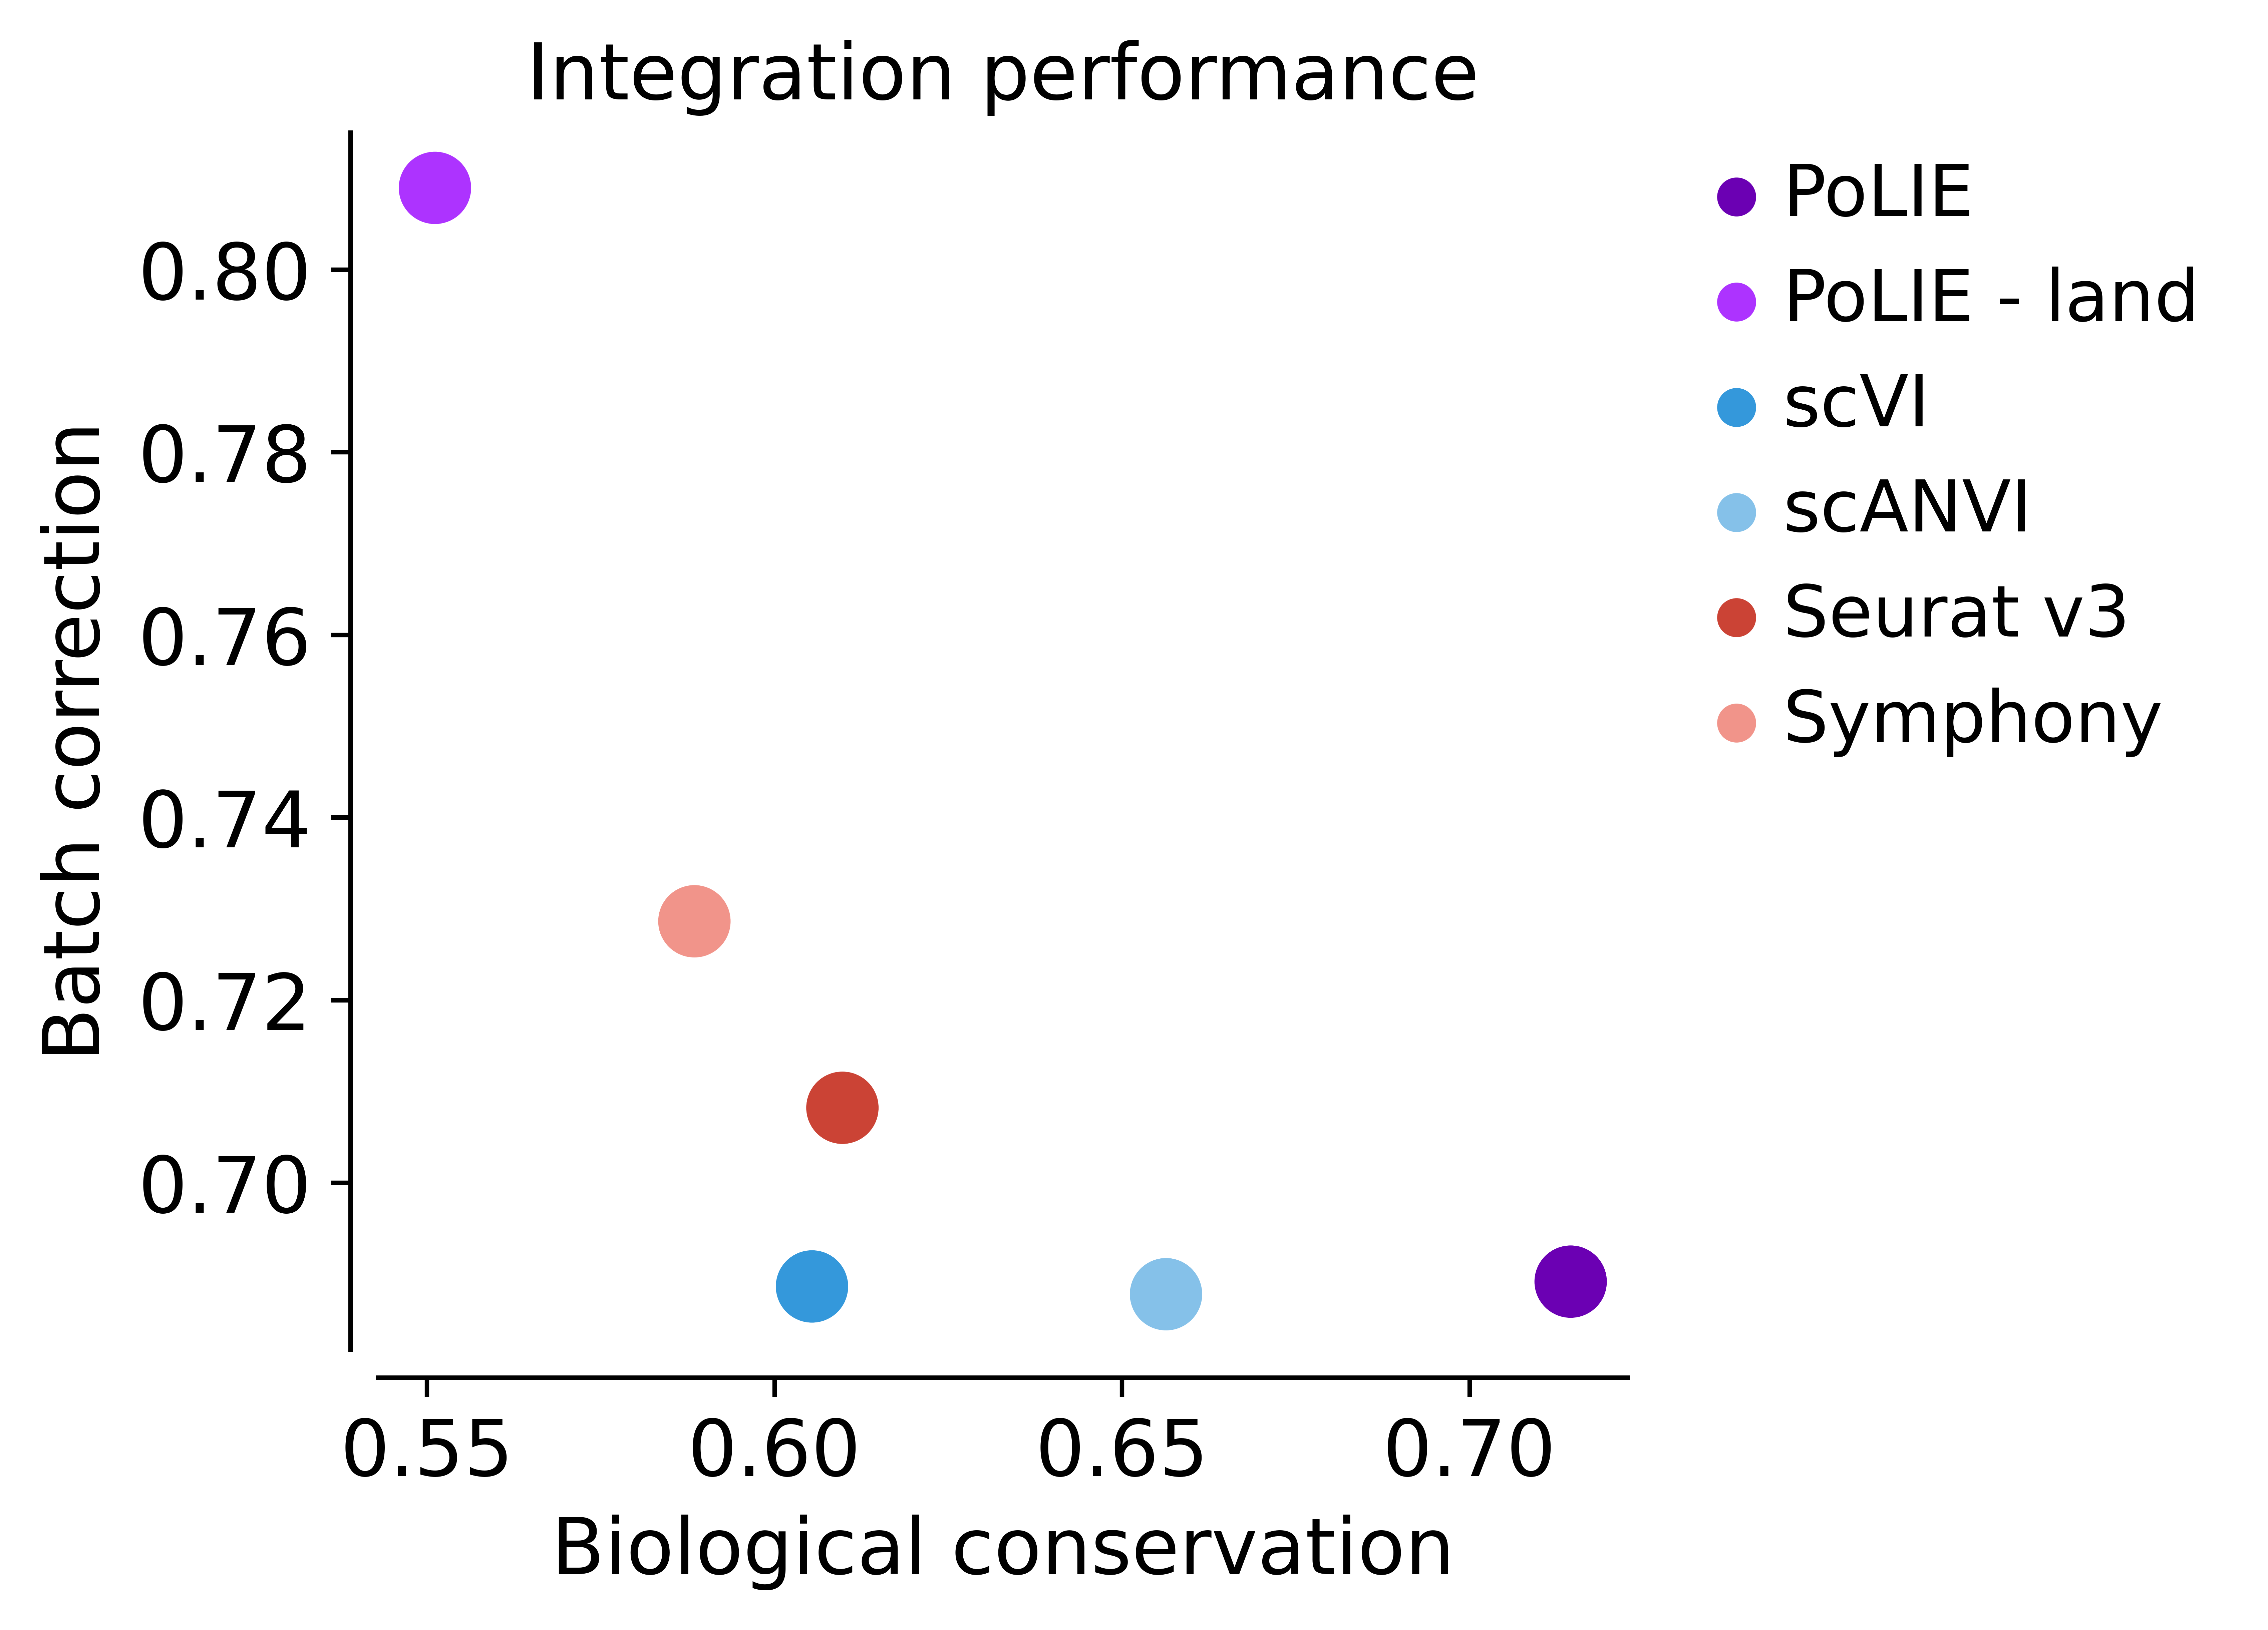

In [48]:
df_plot = results_melt[
    (results_melt['method'].isin(integration_methods))
]
df_plot['method'] = df_plot['method'].cat.remove_unused_categories()

mean_df = df_plot.groupby(['method', 'metric_type']).mean()
mean_df = mean_df.reset_index()
mean_df['index'] = 'avg'
mean_df.columns = ['method', 'metric_type', 'value', 'config.data']
df_plot = df_plot.append(mean_df)
d = df_plot[df_plot['config.data'] == 'avg'].set_index(['method', 'metric_type']).unstack()['value']

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
sns.scatterplot(
    d['bio conservation'], 
    d['batch correction'],
    palette=palette_dict,
    hue=d.index, 
    ax=ax,
    s=200,
)
ax.set_title('Integration performance')
ax.set_ylabel('Batch correction')
ax.set_xlabel('Biological conservation')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., frameon=False)
ax.grid('off')
ax.grid(b=None)
sns.despine(offset=5)
fig.savefig('figure2/benchmark_biobatch.png', dpi=600, bbox_inches='tight')

In [49]:
df_plot = results_melt[
    (results_melt['method'].isin(classification_methods))
    & (results_melt['variable'] == 'result.f1-score-macro')
]
df_plot['method'] = df_plot['method'].cat.remove_unused_categories()

mean_df = df_plot.groupby('method').mean()
mean_df = mean_df.reset_index()
mean_df['index'] = 'avg'
mean_df.columns = ['method', 'value', 'config.data']
df_plot = df_plot.append(mean_df)

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.barplot(
    x='config.data',
    y='value',
    hue='method',
    data=df_plot,
    palette=palette_dict,
    ax=ax
)
ax.set_title('F1 Macro')
ax.set_ylabel('Value')
ax.set_xlabel('Dataset')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., frameon=False)
ax.set_ylim([0, 1])
ax.grid('off')
ax.grid(b=None)
sns.despine(offset=5)
fig.savefig('figure2/benchmark_f1macro.png', dpi=600, bbox_inches='tight')

<ipython-input-49-d072861a3378>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['method'] = df_plot['method'].cat.remove_unused_categories()


In [50]:
df_plot = results_melt[
    (results_melt['method'].isin(classification_methods))
    & (results_melt['variable'] == 'result.f1-score-weighted')
]
df_plot['method'] = df_plot['method'].cat.remove_unused_categories()

mean_df = df_plot.groupby('method').mean()
mean_df = mean_df.reset_index()
mean_df['index'] = 'avg'
mean_df.columns = ['method', 'value', 'config.data']
df_plot = df_plot.append(mean_df)

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.barplot(
    x='config.data',
    y='value',
    hue='method',
    data=df_plot,
    palette=palette_dict,
    ax=ax
)
ax.set_title('F1 Weighted')
ax.set_ylabel('Value')
ax.set_xlabel('Dataset')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., frameon=False)
ax.set_ylim([0, 1])
ax.grid('off')
ax.grid(b=None)
sns.despine(offset=5)
fig.savefig('figure2/benchmark_f1weighted.png', dpi=600, bbox_inches='tight')

<ipython-input-50-892a9ecf533b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['method'] = df_plot['method'].cat.remove_unused_categories()


In [51]:
results_melt

,config.data,method,variable,value,metric_type
108,pancreas,scANVI,result.NMI_cluster/label,0.925007,bio conservation
109,pbmc,scANVI,result.NMI_cluster/label,0.886107,bio conservation
110,brain,scANVI,result.NMI_cluster/label,0.711047,bio conservation
111,scvelo,scANVI,result.NMI_cluster/label,0.612339,bio conservation
112,tumor,scANVI,result.NMI_cluster/label,0.474573,bio conservation
...,...,...,...,...,...
859,pbmc,Symphony,integration_scores_weighted_mean,0.757735,NaN
860,scvelo,Symphony,integration_scores_weighted_mean,0.545792,NaN
861,lung,Symphony,integration_scores_weighted_mean,0.612712,NaN
862,tumor,Symphony,integration_scores_weighted_mean,0.548210,NaN


In [56]:
df_plot = results_melt.pivot(index=['config.data', 'method'], values='value', columns='variable').reset_index()
df_plot = df_plot[df_plot['method'].isin(['PoLIE', 'trVAE + land','scANVI', 'Seurat v3'])]
df_plot['method'] = df_plot['method'].astype('category').cat.remove_unused_categories()
df_mean = df_plot.groupby('method').mean()
df_std = df_plot.groupby('method').std()
df_bottom = df_plot.groupby('method').quantile(0.05)
df_bottom = df_mean - df_bottom
df_top = df_plot.groupby('method').quantile(0.95)
df_top = df_top - df_mean

In [57]:
df_mean

variable,batch_correction_mean,bio_conservation_mean,integration_scores_mean,integration_scores_weighted_mean,result.ARI_cluster/label,result.ASW_label,result.ASW_label/batch,result.NMI_cluster/label,result.PCR_batch,result.f1-score-macro,result.f1-score-weighted,result.graph_conn,result.isolated_label_F1,result.isolated_label_silhouette
method,,,,,,,,,,,,,,
PoLIE,0.689169,0.714558,0.705037,0.704403,0.651794,0.748229,0.750635,0.781664,0.350445,0.626485,0.754200,0.966427,0.715536,0.675567
trVAE + land,0.698018,0.709548,0.705225,0.704936,0.690841,0.717192,0.788221,0.795590,0.345991,0.644540,0.745917,0.959843,0.661804,0.682315
scANVI,0.687789,0.656341,0.668134,0.668920,0.633449,0.589538,0.843314,0.731906,0.253095,0.506257,0.710112,0.966959,0.732638,0.594172
Seurat v3,0.708210,0.609780,0.646691,0.649152,0.592544,0.565028,0.865436,0.689035,0.286913,0.637115,0.736303,0.972280,0.599296,0.602999


/home/icb/carlo.dedonno/anaconda3/envs/lataq_cuda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


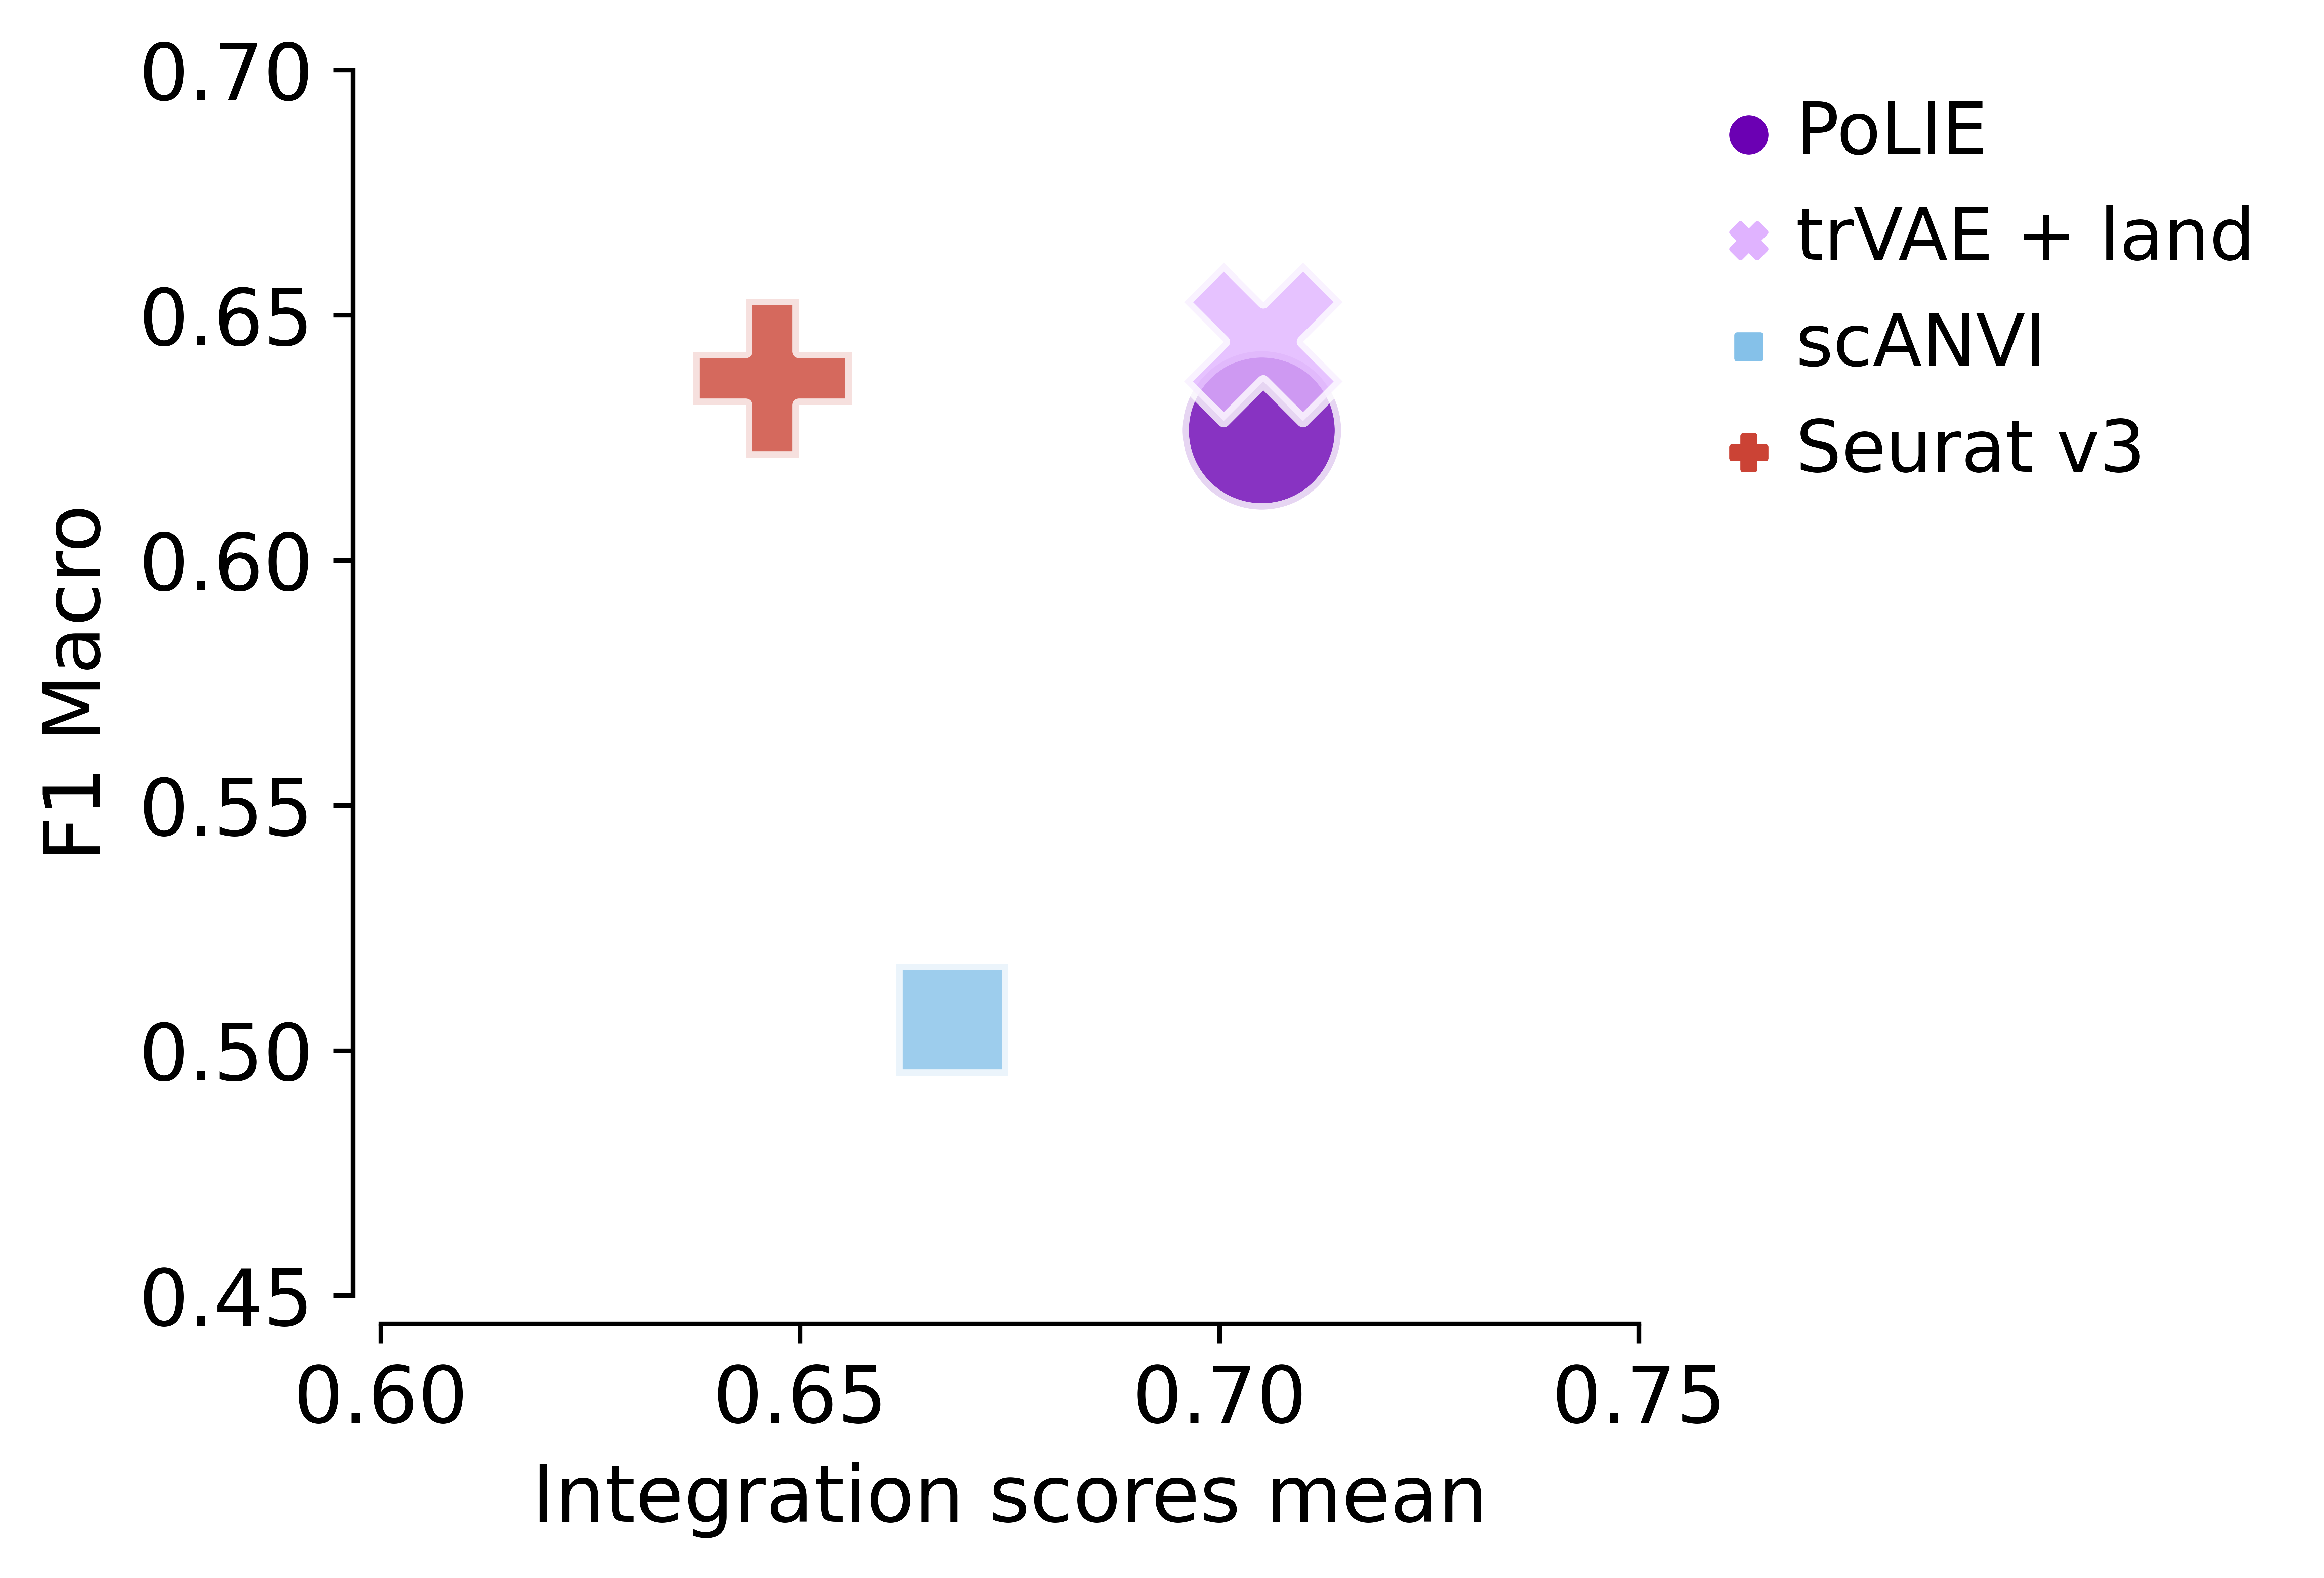

In [58]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
sns.scatterplot(
    df_mean['integration_scores_mean'],
    df_mean['result.f1-score-macro'],
    hue=df_mean.index,
    style=df_mean.index,
    palette=palette_dict,
    ax=ax,
    s=800,
    alpha=0.8,
)
ax.set_ylabel('F1 Macro')
ax.set_xlabel('Integration scores mean')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., frameon=False)
ax.set_xlim([0.6, 0.75])
ax.set_ylim([0.45, 0.7])
ax.grid('off')
ax.grid(b=None)
sns.despine(offset=5)
fig.savefig('figure2/benchmark_comparison_f1macro.png', dpi=600, bbox_inches='tight')

/home/icb/carlo.dedonno/anaconda3/envs/lataq_cuda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


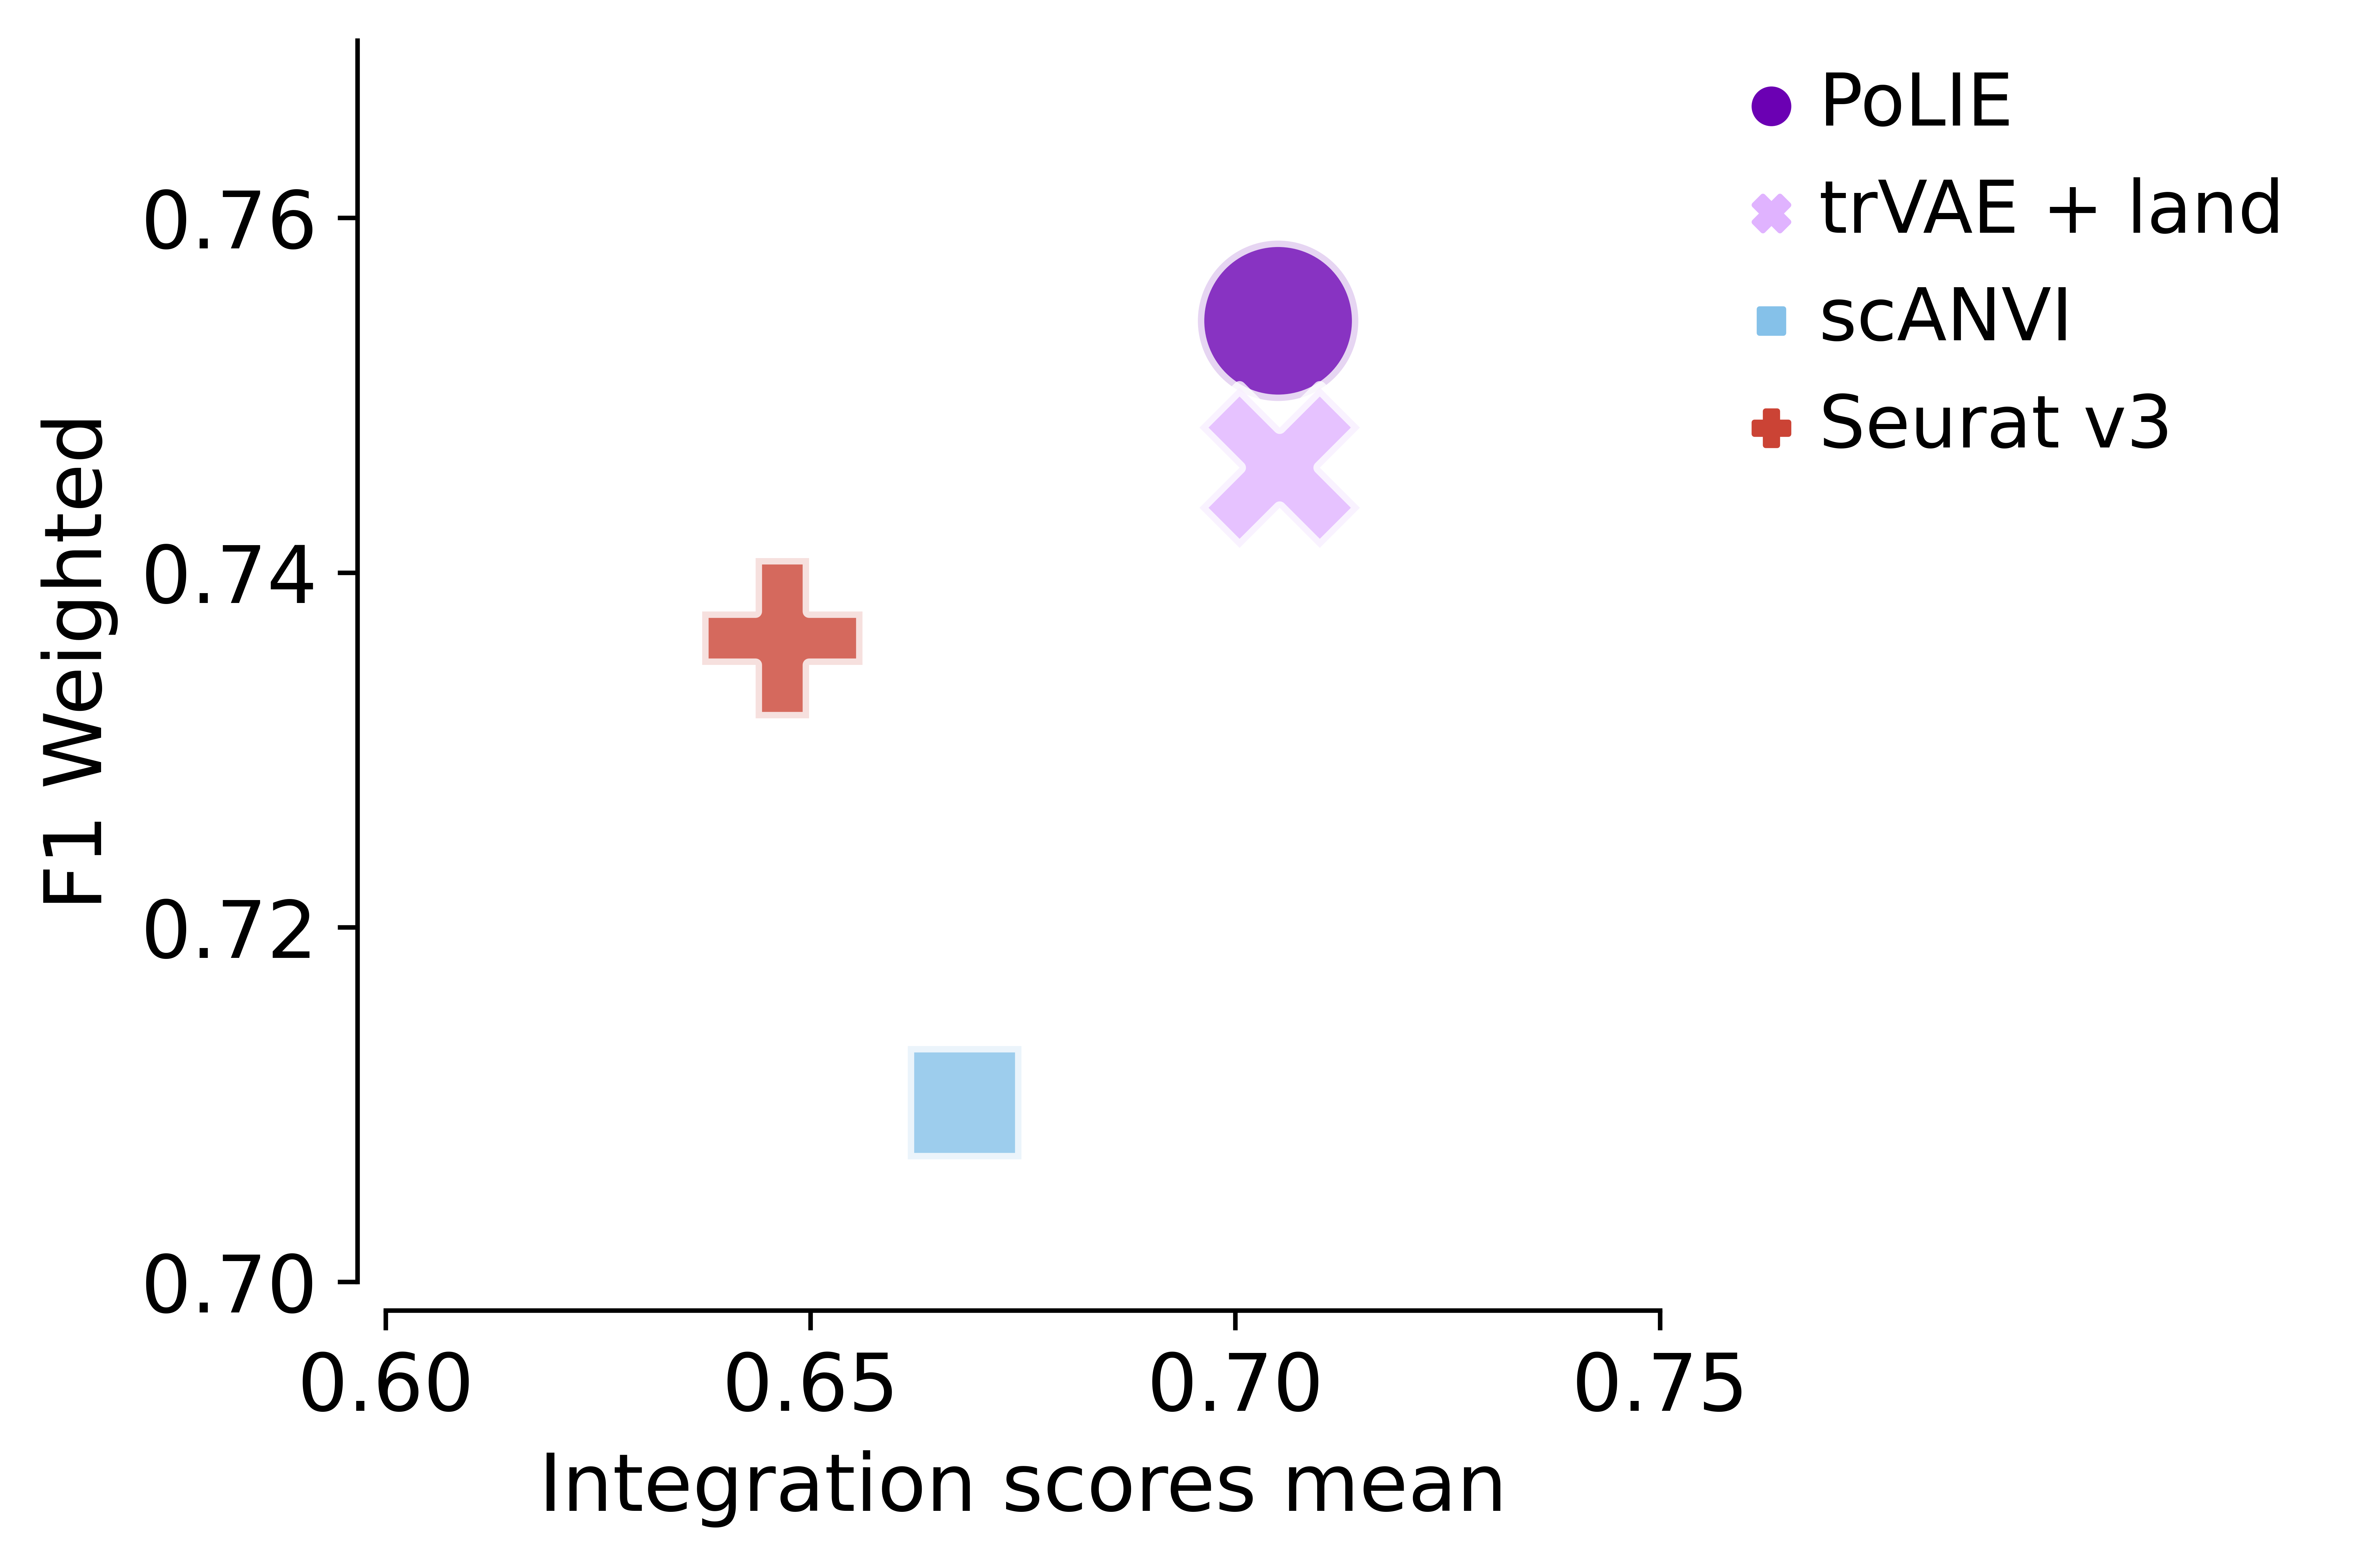

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
sns.scatterplot(
    df_mean['integration_scores_mean'],
    df_mean['result.f1-score-weighted'],
    hue=df_mean.index,
    style=df_mean.index,
    palette=palette_dict,
    ax=ax,
    s=800,
    alpha=0.8,
)
ax.set_ylabel('F1 Weighted')
ax.set_xlabel('Integration scores mean')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., frameon=False)
ax.set_xlim([0.6, 0.75])
ax.set_ylim([0.7, 0.77])
ax.grid('off')
ax.grid(b=None)
sns.despine(offset=5)
fig.savefig('figure2/benchmark_comparison_f1weighted.png', dpi=600, bbox_inches='tight')